## Auto Regressive Models for Price Returns Forecasting
* Use of AR based models to perform h-step ahead forecasts for h Week Price Returns
* The best AR model will serve as our baseline by using only univariate time series

### Approach
1. Data Analysis & Preparation
2. Modelling w/ Tuning & Forecast Evaluation

TBD:
1. Try out different Error Metrics (i.e. MSE, RMSE, MAE)
2. Jot down ARIMA parameters
3. Try out VARIMA
4. Save models

### Set Up

In [1]:
# NB config
%load_ext autoreload
%autoreload 2

# Load Libraries
import os

os.chdir("../../")
import pandas as pd
import numpy as np
from pathlib import Path
from darts import TimeSeries
from darts.metrics import mape, mse, rmse
from darts.utils import statistics as dstats
from darts.models.forecasting.auto_arima import (
    AutoARIMA,
)
from darts.models.forecasting.baselines import (
    NaiveDrift,
    NaiveMean,
)

import warnings

warnings.filterwarnings("ignore")

/Users/christopherliew/Desktop/Y4S1/HT/crypto_uncertainty_index/.venv/crypto-uncertainty-index-SX872G0E-py3.8/lib/python3.8/site-packages/darts/timeseries.py:39: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.DatetimeIndex, pd.RangeIndex, pd.Int64Index)
/Users/christopherliew/Desktop/Y4S1/HT/crypto_uncertainty_index/.venv/crypto-uncertainty-index-SX872G0E-py3.8/lib/python3.8/site-packages/darts/timeseries.py:512: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  times: Union[pd.DatetimeIndex, pd.Int64Index],
/Users/christopherliew/Desktop/Y4S1/HT/crypto_uncertainty_index/.venv/crypto-uncertainty-index-SX872G0E-py3.8/lib/python3.8/site-packages/darts/timeseries.py:738: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a fu

### 1. Data Analysis & Preparation
#### Load Datasets

In [2]:
# Data Dir
data_dir = Path("forecasting/data/modelling")
btc_usd_fp = data_dir / "btc_usd_weekly.csv"
btc_usd_df = pd.read_csv(btc_usd_fp)
btc_usd_df.describe()

,Price,Volume
count,381.000000,3.810000e+02
mean,10839.550218,1.010428e+11
std,15837.781625,1.324745e+11
min,210.339005,8.067957e+07
25%,606.718994,5.526426e+08
50%,6008.419922,3.426173e+10
75%,10256.058594,1.730165e+11
max,65466.839844,7.666798e+11


#### Create ***h***-weeks Log Price Returns

In [3]:
# h = 1 (Weekly Price Returns)
btc_usd_df["Price Returns (h=1)"] = np.log1p(btc_usd_df[["Price"]].pct_change(1))

# h = 4 (4 Week Price Returns)
btc_usd_df["Price Returns (h=4)"] = np.log1p(btc_usd_df[["Price"]].pct_change(4))

# h = 12 (12 Week Price Returns)
btc_usd_df["Price Returns (h=12)"] = np.log1p(btc_usd_df[["Price"]].pct_change(12))

# Preview
btc_usd_df.head()

,Date,Price,Volume,Price Returns (h=1),Price Returns (h=4),Price Returns (h=12)
0,2014-09-15,398.821014,156903400.0,NaN,NaN,NaN
1,2014-09-22,377.181000,186772600.0,-0.055788,NaN,NaN
2,2014-09-29,320.510010,276657896.0,-0.162812,NaN,NaN
3,2014-10-06,378.549011,341152804.0,0.166432,NaN,NaN
4,2014-10-13,389.545990,156902070.0,0.028636,-0.023531,NaN


In [4]:
# Create TimeSeries
# h = 1 (Weekly Price Returns)
btc_usd1_ts = TimeSeries.from_dataframe(
    btc_usd_df[["Date", "Price Returns (h=1)"]].dropna(), time_col="Date"
)

# h = 4 (4 Week Price Returns)
btc_usd4_ts = TimeSeries.from_dataframe(
    btc_usd_df[["Date", "Price Returns (h=4)"]].dropna(), time_col="Date"
)

# h = 12 (12 Week Price Returns)
btc_usd12_ts = TimeSeries.from_dataframe(
    btc_usd_df[["Date", "Price Returns (h=12)"]].dropna(), time_col="Date"
)

#### Train Test Split
* We split down the date when Libra by Facebook was roughly announced. Also, we want the Test period to contain sufficient periods of pre-covid data since post covid volatility exploded. (OR SHOULD WE INCLUDE POST COVID DATA AND LEAVE TEST AS A SUBSAMPLE OF COVID DATA?)
* Train Period: 2014-09-15 to 2019-05-27 (246 Observations)
* Test Period: 2019-06-03 to 2021-12-27 (135 Observations)
* Since we are using Darts Backtesting + Historical Forecast we do not need to split it here. But we can visualise as follows

In [5]:
# Split into Train and Test
split_date = pd.Timestamp("20190527")

In [6]:
def show_train_test(df: TimeSeries, split_date: pd.Timestamp) -> None:
    train, val = df.split_before(split_date)
    train.plot(label="Training")
    val.plot(label="Validation")

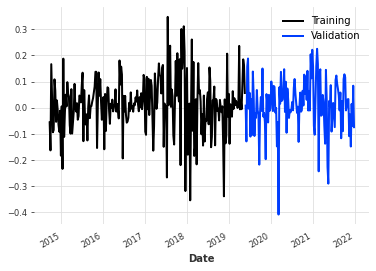

In [7]:
# h = 1
show_train_test(btc_usd1_ts, split_date)

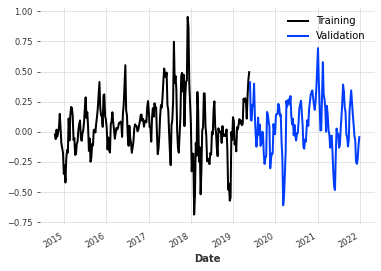

In [8]:
# h = 4
show_train_test(btc_usd4_ts, split_date)

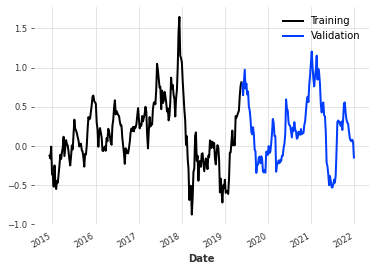

In [9]:
# h = 12
show_train_test(btc_usd12_ts, split_date)

#### Naive Benchmark Model

In [10]:
naive1 = NaiveDrift()

# Historical Forecast

hfcast_n1 = naive1.historical_forecasts(
    btc_usd1_ts, start=split_date, forecast_horizon=1, verbose=True
)

  0%|          | 0/136 [00:00<?, ?it/s]

In [11]:
# Errors

average_error = naive1.backtest(
    btc_usd1_ts,
    start=split_date,
    forecast_horizon=11,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

  0%|          | 0/126 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 352.99


In [12]:
naive4 = NaiveDrift()

# Historical Forecast

hfcast_n1 = naive4.historical_forecasts(
    btc_usd4_ts, start=split_date, forecast_horizon=4, verbose=True
)

  0%|          | 0/133 [00:00<?, ?it/s]

In [13]:
# Errors

average_error = naive4.backtest(
    btc_usd4_ts,
    start=split_date,
    forecast_horizon=4,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

  0%|          | 0/133 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 2001.94


In [14]:
naive12 = NaiveDrift()

# Historical Forecast

hfcast_n12 = naive12.historical_forecasts(
    btc_usd12_ts, start=split_date, forecast_horizon=12, verbose=True
)

  0%|          | 0/125 [00:00<?, ?it/s]

In [15]:
# Errors

average_error = naive12.backtest(
    btc_usd12_ts,
    start=split_date,
    forecast_horizon=12,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

  0%|          | 0/125 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 189.61


#### Time Series Analysis & Preprocessing

##### Stationarity

In [16]:
print([dstats.stationarity_tests(i) for i in [btc_usd1_ts, btc_usd4_ts, btc_usd12_ts]])

[True, True, True]


##### ACF (Sharp Cut Off)

For h = 1 we start with MA(1) based on the ACF below:

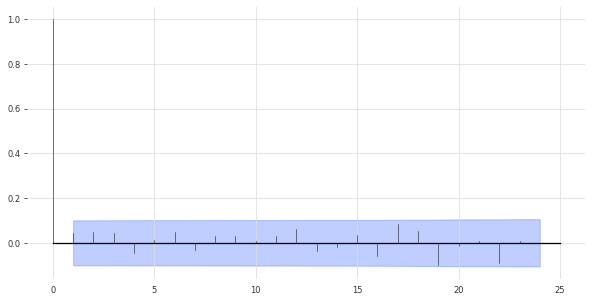

In [17]:
dstats.plot_acf(btc_usd1_ts)

For h = 4 we start with MA(3) based on the ACF below:

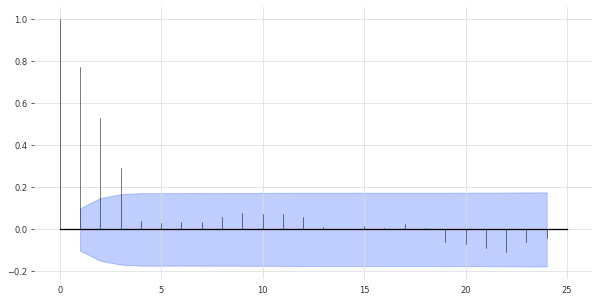

In [18]:
dstats.plot_acf(btc_usd4_ts)

For h = 12 we start with MA(1) based on the ACF below:

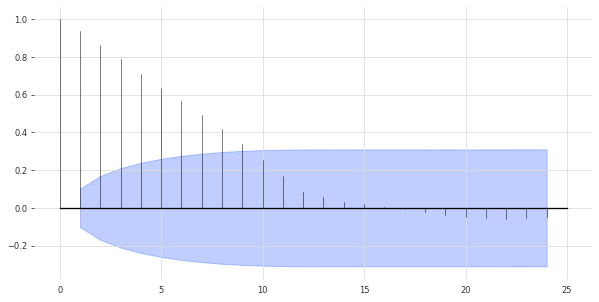

In [19]:
dstats.plot_acf(btc_usd12_ts)

##### PACF (Significant Lags)

For h = 1 we start with AR(19) based on the PACF below:

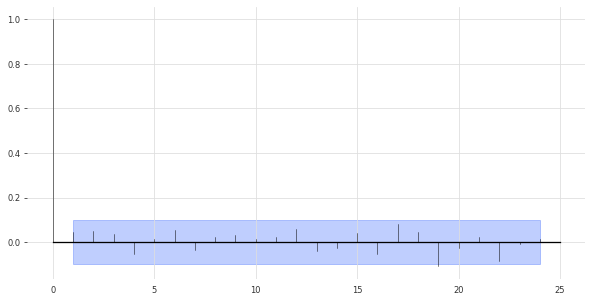

In [20]:
dstats.plot_pacf(btc_usd1_ts)

For h = 4 we start with AR(5) based on the PACF below:

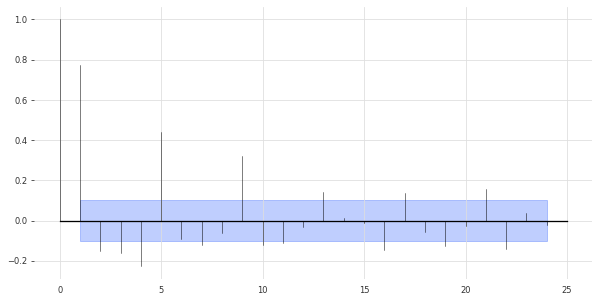

In [21]:
dstats.plot_pacf(btc_usd4_ts)

For h = 12 we start with AR(1) based on the PACF below:

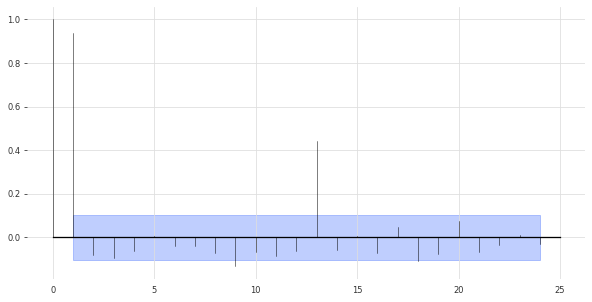

In [22]:
dstats.plot_pacf(btc_usd12_ts)

### 2. Modelling & Forecast Evaluation (ARIMA)

#### h = 1

In [23]:
# AutoARIMA Model

aa1_kwargs = {
    "start_p": 1,
    "start_q": 1,
    "max_p": 5,
    "max_q": 5,
    "n_jobs": -1,
}

aa1_model = AutoARIMA(autoarima_kwargs=aa1_kwargs)

In [24]:
# Historical Forecast

hfcast_aa1 = aa1_model.historical_forecasts(
    btc_usd1_ts, start=split_date, forecast_horizon=1, verbose=True
)

  0%|          | 0/136 [00:00<?, ?it/s]

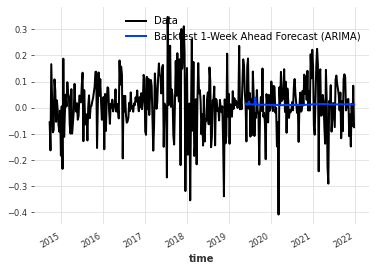

In [25]:
# Plot Forecast

btc_usd1_ts.plot(label="Data")
hfcast_aa1.plot(label="Backtest 1-Week Ahead Forecast (ARIMA)")

In [26]:
# Errors

average_error = aa1_model.backtest(
    btc_usd1_ts,
    start=split_date,
    forecast_horizon=1,
    metric=rmse,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (RMSE) over all historical forecasts: %.4f" % average_error)

  0%|          | 0/136 [00:00<?, ?it/s]

Average error (RMSE) over all historical forecasts: 0.0748


#### h = 4

In [27]:
# AutoARIMA Model

aa4_kwargs = {
    "start_p": 5,
    "start_q": 3,
    "max_p": 10,
    "max_q": 5,
    "n_jobs": -1,
}

aa4_model = AutoARIMA(autoarima_kwargs=aa4_kwargs)

In [28]:
# Historical Forecast

hfcast_aa4 = aa4_model.historical_forecasts(
    btc_usd4_ts, start=split_date, forecast_horizon=4, verbose=True
)

  0%|          | 0/133 [00:00<?, ?it/s]

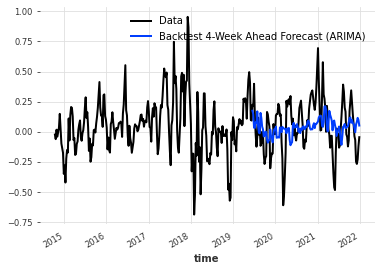

In [29]:
# Plot Forecast

btc_usd4_ts.plot(label="Data")
hfcast_aa4.plot(label="Backtest 4-Week Ahead Forecast (ARIMA)")

In [30]:
# Errors

average_error_4 = aa4_model.backtest(
    btc_usd4_ts,
    start=split_date,
    forecast_horizon=4,
    metric=rmse,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (RMSE) over all historical forecasts: %.4f" % average_error)

  0%|          | 0/133 [00:00<?, ?it/s]

Average error (RMSE) over all historical forecasts: 0.0748


#### h = 12

In [31]:
# AutoARIMA Model

aa12_kwargs = {
    "start_p": 1,
    "start_q": 1,
    "max_p": 13,
    "max_q": 9,
    "n_jobs": -1,
}

aa12_model = AutoARIMA(autoarima_kwargs=aa12_kwargs)

In [32]:
# Historical Forecast

hfcast_aa12 = aa12_model.historical_forecasts(
    btc_usd12_ts, start=split_date, forecast_horizon=12, verbose=True
)

  0%|          | 0/125 [00:00<?, ?it/s]

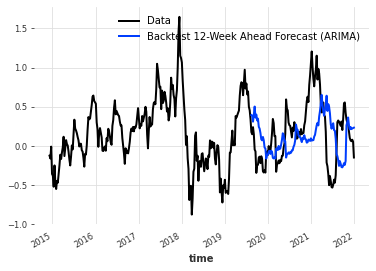

In [33]:
# Plot Forecast

btc_usd12_ts.plot(label="Data")
hfcast_aa12.plot(label="Backtest 12-Week Ahead Forecast (ARIMA)")

In [34]:
# Errors

average_error_12 = aa12_model.backtest(
    btc_usd12_ts,
    start=split_date,
    forecast_horizon=12,
    metric=mse,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (RMSE) over all historical forecasts: %.4f" % average_error)

  0%|          | 0/125 [00:00<?, ?it/s]

Average error (RMSE) over all historical forecasts: 0.0748


### Naive Mean Model for h = 1 to 12
#### Compute Errors with Backtest

In [35]:
horizons = list(range(1, 13))

In [55]:
# Save Forecast Results
data_dir = Path("forecasting/data/forecasts/mean_model")

In [36]:
def gen_log_price_returns(series: pd.DataFrame,
                          h: int,
                          date_col: str = "Date",
                          var_col: str = "Price"
                          ) -> TimeSeries:
    new_col_name = f"Price Returns (h={h})"
    series[new_col_name] = (
        np.log1p(series[[var_col]].pct_change(h))
    )
    new_ts = TimeSeries.from_dataframe(
       series[[date_col, new_col_name]].dropna(),
       time_col=date_col 
    )
    return new_ts

In [40]:
naive_mean_errors = {}

for h in horizons:
    model = NaiveMean()
    series = gen_log_price_returns(btc_usd_df, h)
    ave_error = model.backtest(
        series,
        start=split_date,
        forecast_horizon=h,
        verbose=True,
    )
    naive_mean_errors[h] = ave_error


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [54]:
naive_mean_forecast_errors = (
    pd.DataFrame(naive_mean_errors.values(),
                 index=naive_mean_errors.keys())
    .reset_index()
    .rename(columns={'index': 'horizon', 0: 'rmse'})
)

naive_mean_forecast_errors

,horizon,rmse
0,1,124.086791
1,2,135.775590
2,3,198.497333
3,4,649.496624
4,5,204.506011
5,6,128.001048
6,7,148.805658
7,8,142.423493
8,9,126.456758
9,10,184.017170


In [56]:
naive_mean_forecast_errors.to_csv(data_dir / "mean_model_errors.csv", index=False)

### Get Historical Forecasts

In [41]:
all_hist_forecasts = {}

for h in horizons:
    model = NaiveMean()
    series = gen_log_price_returns(btc_usd_df, h)
    hist_forecasts = model.historical_forecasts(
        series,
        start=split_date,
        forecast_horizon=h,
        verbose=True,
    )
    all_hist_forecasts[h] = hist_forecasts


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [59]:
for h, v in all_hist_forecasts.items():
    forecast_df = v.with_columns_renamed(['0'], ['price_return'])
    forecast_df.to_csv(data_dir / f"mean_model_h{h}.csv")
